In [8]:
from log_parser import parse_keyboard_log
from keyboard_heatmap import KeyboardHeatmap

# Segment length of each data sample
seg_length = 100

# List of parsed logfiles
keyboard = []
keyboard.append(parse_keyboard_log("./logs/JON/SPY/keyboard_actions.log"))
keyboard.append(parse_keyboard_log("./logs/MAR/SOL/keyboard_actions.log"))
keyboard.append(parse_keyboard_log("./logs/HEN/SOL/keyboard_actions.log"))
keyboard.append(parse_keyboard_log("./logs/ZIR/SOL/keyboard_actions.log"))
keyboard.append(parse_keyboard_log("./logs/MIT/SOL/keyboard_actions.log"))

# Empty lists for inserting data
X_actual = []
Y_actual = []

for k in range(len(keyboard)):
    for i in range(int(keyboard[k].time.iloc[-1] / seg_length)):
        # For each segment in each logfile
        # Create a heatmap for that segment
        heatmap = KeyboardHeatmap(keyboard[k], i, seg_length)
        # If the heatmap isn't blank
        if heatmap.class_label() != 'Null':
            X_actual.append(heatmap.heatmap_data().ravel().tolist())
            Y_actual.append(heatmap.class_label())

print(f"Data samples: {len(Y_actual)}")


Data samples: 181


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# Split into train and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X_actual, Y_actual, random_state=0)

# Create random forests classifier object
# n_jobs controls multithreading, -1 uses all available threads
# criterion determines how well a feature splits data, we use gini
# max_features determines the number of candidate features available for a best split
# n_estimators determines the number of trees in our forest
# oob_score determines whether or not our forest uses out of bag error
rfc = RandomForestClassifier(n_jobs=-1, criterion='gini', max_features= 'sqrt', n_estimators = 100, oob_score = True) 

model = rfc.fit(X_train, Y_train)

# Print best score
print( 
    f"Train score: {rfc.score(X_train, Y_train)} " +
    f"Test score: {rfc.score(X_test, Y_test)}"
)

# Predict on test set
Y_predict = rfc.predict(X_test)

scores = cross_val_score(rfc, X_actual, Y_actual, cv=5)
scores

Train score: 1.0 Test score: 0.9130434782608695
Actual: HENSOL      -  Predicted: HENSOL
Actual: JONSPY      -  Predicted: JONSPY
Actual: MARSOL      -  Predicted: MARSOL
Actual: MITSOL      -  Predicted: MITSOL
Actual: ZIRSOL      -  Predicted: MITSOL
Actual: MARSOL      -  Predicted: MARSOL
Actual: ZIRSOL      -  Predicted: ZIRSOL
Actual: ZIRSOL      -  Predicted: ZIRSOL
Actual: MITSOL      -  Predicted: ZIRSOL
Actual: ZIRSOL      -  Predicted: ZIRSOL
Actual: JONSPY      -  Predicted: JONSPY
Actual: MITSOL      -  Predicted: MITSOL
Actual: MITSOL      -  Predicted: MITSOL
Actual: JONSPY      -  Predicted: JONSPY
Actual: JONSPY      -  Predicted: JONSPY
Actual: ZIRSOL      -  Predicted: ZIRSOL
Actual: ZIRSOL      -  Predicted: MITSOL
Actual: ZIRSOL      -  Predicted: ZIRSOL
Actual: MARSOL      -  Predicted: MARSOL
Actual: HENSOL      -  Predicted: HENSOL
Actual: MARSOL      -  Predicted: MARSOL
Actual: MITSOL      -  Predicted: MITSOL
Actual: HENSOL      -  Predicted: HENSOL
Actual: J

array([0.91891892, 0.91666667, 0.94444444, 0.97222222, 0.94444444])

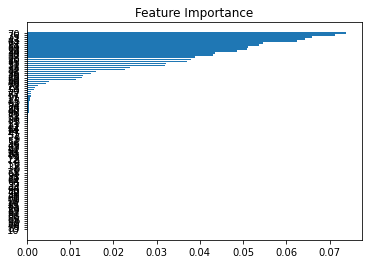

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# We want to plot the feature importance of all features to see how our classifier is splitting data
importances = model.feature_importances_
indices = np.argsort(importances)

# names = [magicFunctionThatGivesNames() for i in indices]

# Barplot
plt.barh(range(len(indices)), importances[indices])
# Add feature names as y-axis labels
# replace [indices[i] for i in indices] with feature labels
plt.yticks(range(len(indices)), [indices[i] for i in indices])
# Create plot title
plt.title("Feature Importance")
# Show plot
plt.show()

[Text(457.9545454545455, 576.5454545454545, 'X[64] <= 0.122\ngini = 0.798\nsamples = 90\nvalue = [31, 28, 24, 26, 26]'),
 Text(380.4545454545455, 521.6363636363636, 'X[71] <= 0.005\ngini = 0.785\nsamples = 80\nvalue = [31, 28, 24, 25, 12]'),
 Text(352.2727272727273, 466.72727272727275, 'X[1] <= 0.335\ngini = 0.776\nsamples = 68\nvalue = [31, 13, 24, 25, 12]'),
 Text(225.45454545454547, 411.8181818181818, 'X[4] <= 0.125\ngini = 0.668\nsamples = 38\nvalue = [30, 11, 2, 5, 12]'),
 Text(169.0909090909091, 356.90909090909093, 'X[58] <= 0.03\ngini = 0.537\nsamples = 28\nvalue = [28, 10, 2, 2, 2]'),
 Text(140.9090909090909, 302.0, 'X[5] <= 0.035\ngini = 0.494\nsamples = 27\nvalue = [28, 10, 0, 2, 2]'),
 Text(112.72727272727273, 247.09090909090912, 'X[84] <= 0.005\ngini = 0.346\nsamples = 22\nvalue = [28, 3, 0, 2, 2]'),
 Text(84.54545454545455, 192.1818181818182, 'X[62] <= 0.01\ngini = 0.719\nsamples = 5\nvalue = [1, 3, 0, 2, 2]'),
 Text(56.36363636363637, 137.2727272727273, 'X[7] <= 1.783\ngi

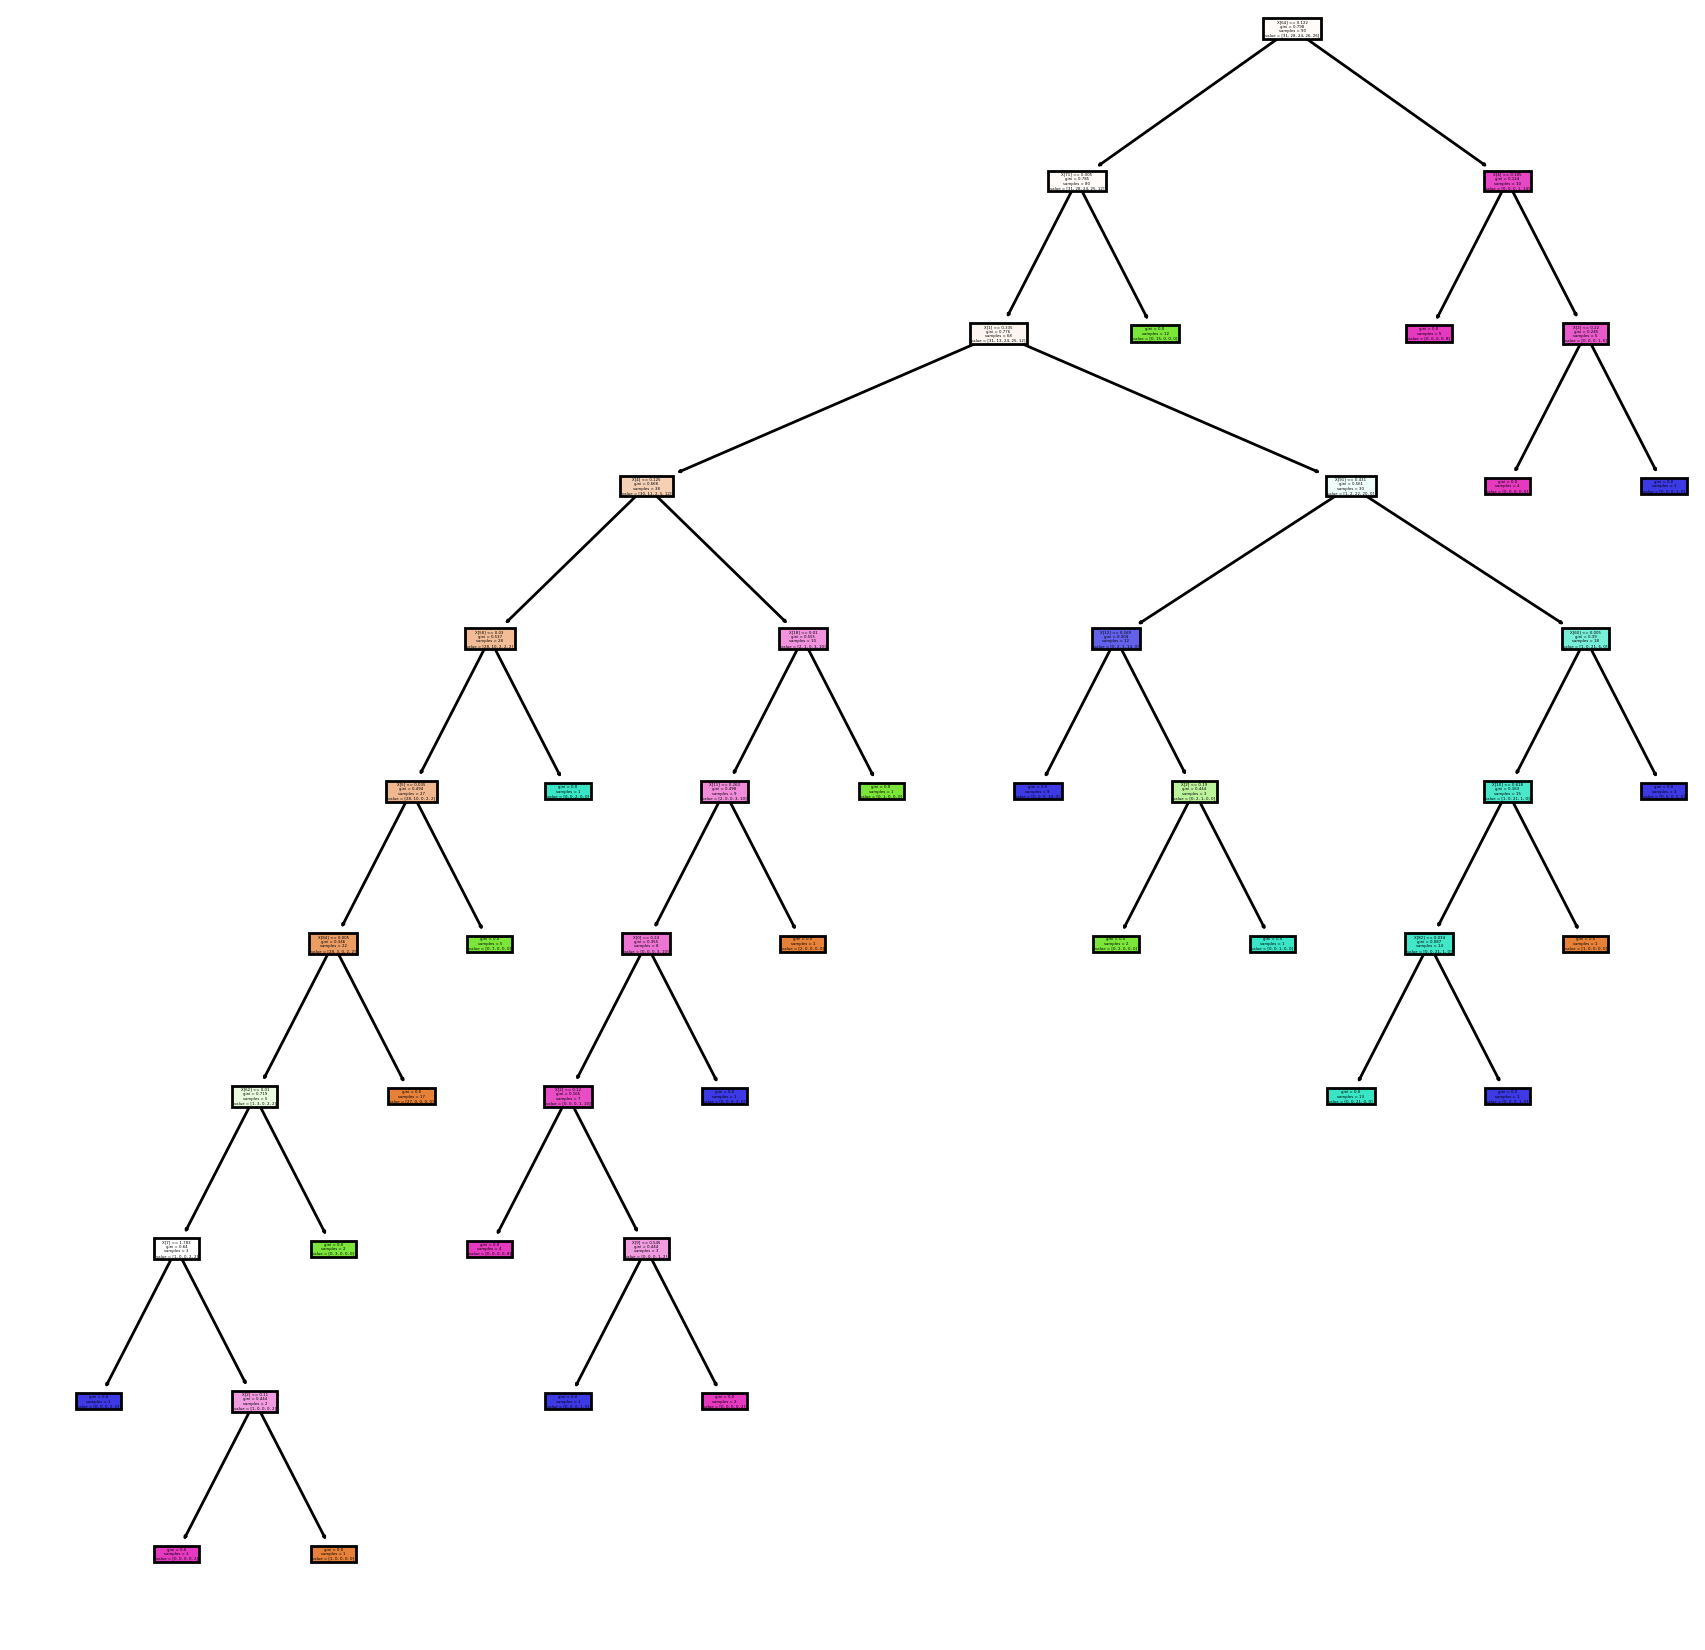

In [ ]:
from sklearn import tree

# Plot one tree in our forest for fun
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=200)
tree.plot_tree(rfc.estimators_[0], filled = True)